In [ ]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score, silhouette_score, classification_report
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
data = pd.read_csv("data.csv")

In [ ]:
# Supprimer la colonne 'Unnamed; 0'
new_data=data.drop(['Unnamed: 0'], axis=1)

In [ ]:
new_data.head()

,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment
0,0.501000,0.405000,0.407000,0.320000,0.365000,0
1,0.497667,0.427000,0.408667,0.290000,0.378333,0
2,0.460600,0.439800,0.421000,0.308400,0.406600,0
3,0.498000,0.454000,0.386000,0.379000,0.402000,0
4,0.458818,0.483091,0.406909,0.297818,0.395273,0


In [ ]:
new_data.shape

(30000, 6)

## Comparative Analysis of Features

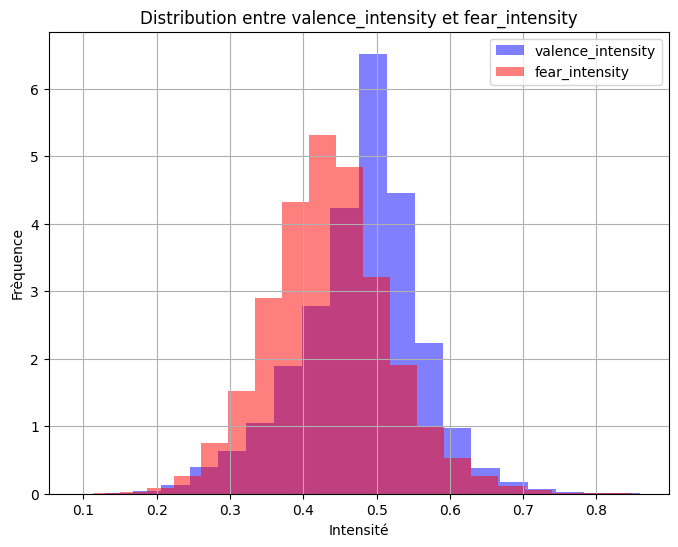

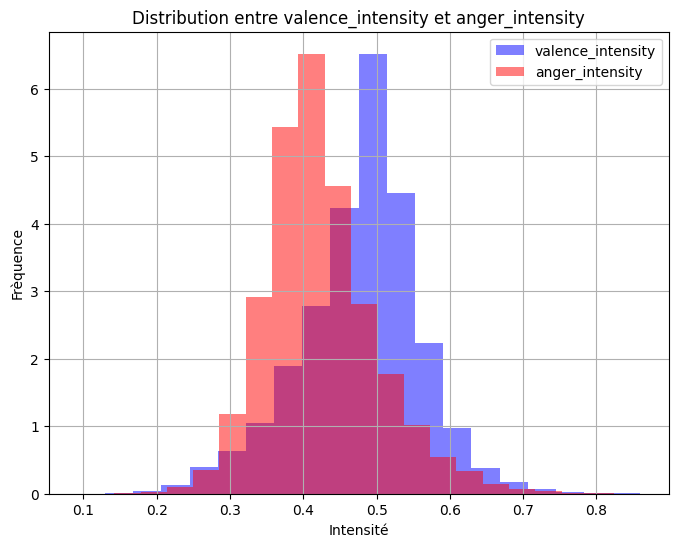

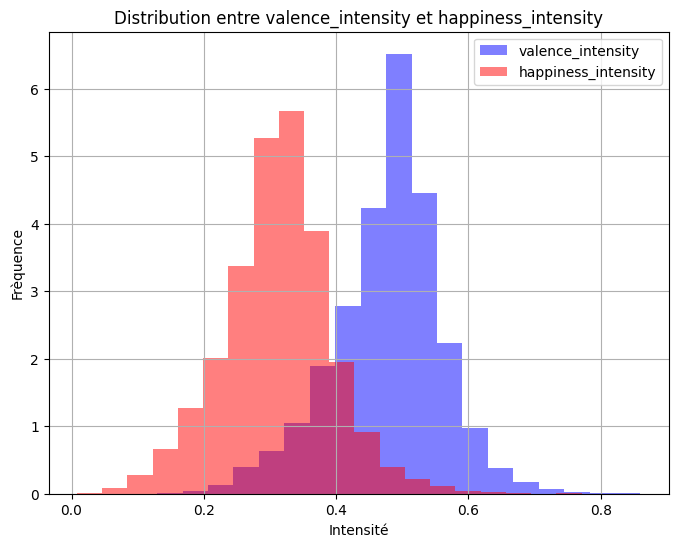

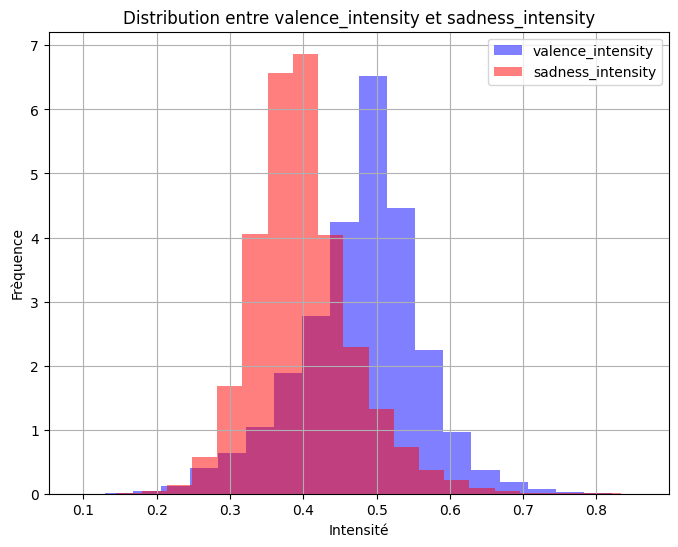

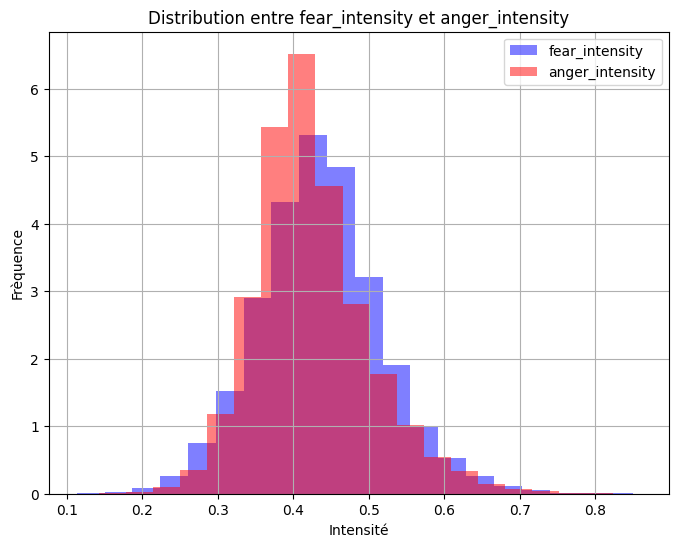

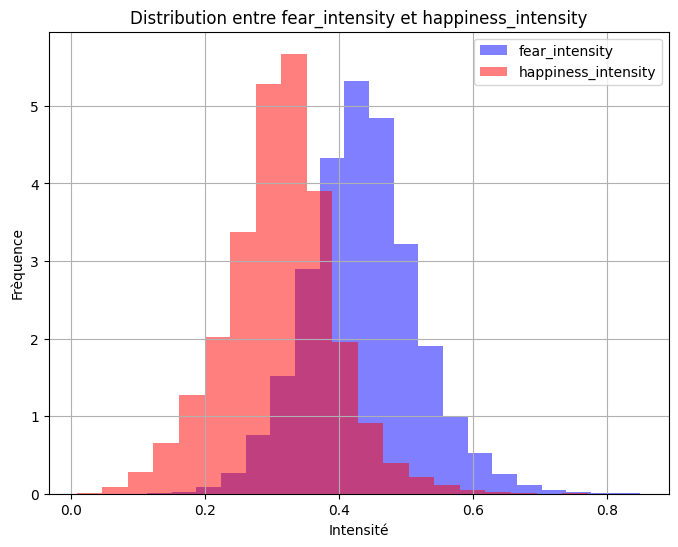

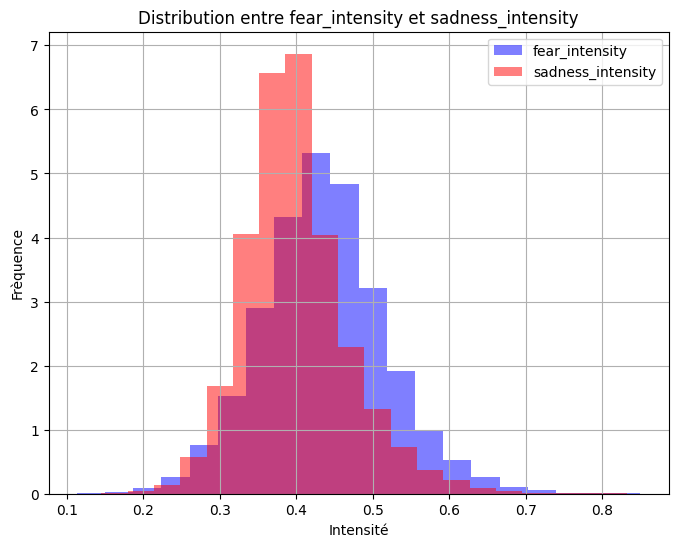

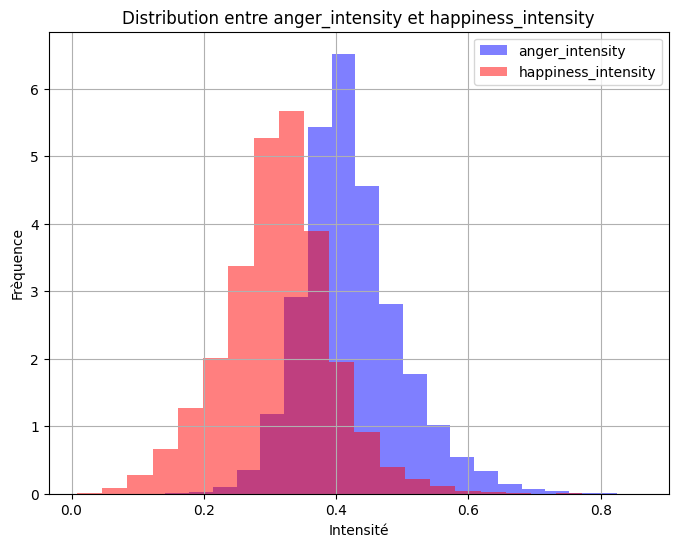

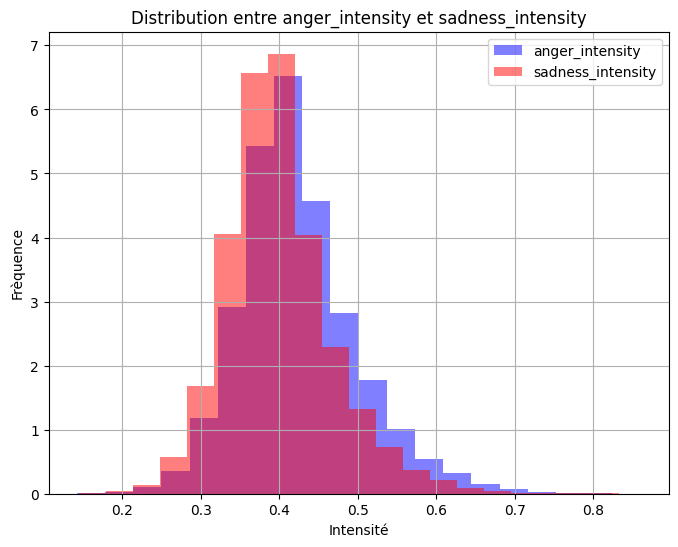

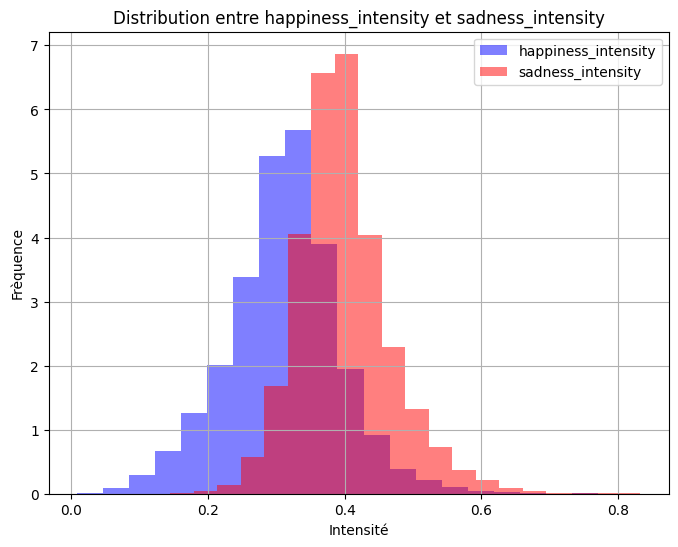

In [ ]:
caracteristiques = ['valence_intensity','fear_intensity', 'anger_intensity', 'happiness_intensity', 'sadness_intensity']

# Créer toutes les paires possibles de caractéristiques
for i, j in combinations(caracteristiques, 2):
    plt.figure(figsize=(8, 6))

    # Tracer les histogrammes superposés pour chaque paire
    sns.histplot(data=data, x=i, bins=20, color='blue', label=i, stat="density", edgecolor='None', alpha=0.5)
    sns.histplot(data=data, x=j, bins=20, color='red', label=j, stat="density", edgecolor='None', alpha=0.5)

    plt.title(f'Distribution entre {i} et {j}')
    plt.xlabel('Intensité')
    plt.ylabel('Frèquence')
    plt.legend(loc='upper right')
    plt.grid(True)

plt.show()

## Clustering with K-means

Définition des fonctions distance_euclidienne, distance_intra_classe, distance_inter_classe et Overlap

In [ ]:
# Fonction de distance euclidienne
def distance_euclidienne(vecteur1, vecteur2):
    return np.sqrt(np.sum((vecteur1 - vecteur2) ** 2))

# Fonction de distance intra-classe avec la distance euclidienne
def distance_intra_classe(dataframe, classe):
    class_dataframe = dataframe[dataframe['Class'] == classe]
    features = class_dataframe.drop(columns=['Class'])
    centre = features.mean().values  # Calculer le centre de la classe
    distances = [distance_euclidienne(x, centre) for x in features.values]
    return max(distances)  # Retourne la distance maximale

# Fonction de distance inter-classe avec la distance euclidienne
def distance_inter_classe(dataframe, classe1, classe2):
    classe1_dataframe = dataframe[dataframe['Class'] == classe1].drop(columns=['Class'])
    classe2_dataframe = dataframe[dataframe['Class'] == classe2].drop(columns=['Class'])
    centre_classe1 = classe1_dataframe.mean().values
    centre_classe2 = classe2_dataframe.mean().values

    dist_c1c2 = float('inf')
    dist_c2c1 = float('inf')

    for x in classe1_dataframe.values:
        dist = distance_euclidienne(x, centre_classe2)
        if dist < dist_c1c2:
            dist_c1c2 = dist

    for x in classe2_dataframe.values:
        dist = distance_euclidienne(x, centre_classe1)
        if dist < dist_c2c1:
            dist_c2c1 = dist

    return min(dist_c1c2, dist_c2c1)

# Fonction d'Overlap
def overlap(distance_intra_classe1, distance_intra_classe2, distance_inter_classe):
    return (distance_intra_classe1 + distance_intra_classe2) / (2 * distance_inter_classe)

Exécution de l'algorithme KMeans pour l'ensemble complet des 5 caractéristiques

In [ ]:
new_data['Class'] = -1  # Placeholder pour les classes

results = {'K': [], 'Overlap': [], 'Silhouette': []}

# Tester avec différentes valeurs de K
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    new_data['Class'] = kmeans.fit_predict(new_data[caracteristiques])

    # Calculer Overlap
    overlap_scores = []
    for classe1, classe2 in combinations(np.unique(new_data['Class']), 2):
        intra_classe1 = distance_intra_classe(new_data, classe1)
        intra_classe2 = distance_intra_classe(new_data, classe2)
        inter_classe = distance_inter_classe(new_data, classe1, classe2)
        overlap_scores.append(overlap(intra_classe1, intra_classe2, inter_classe))

    overlap_avg = np.mean(overlap_scores)

    # Calculer Silhouette Score
    silhouette_avg = silhouette_score(new_data[caracteristiques], new_data['Class'])

    # Sauvegarder les résultats pour chaque K
    results['K'].append(k)
    results['Overlap'].append(overlap_avg)
    results['Silhouette'].append(silhouette_avg)

# Créer un Dataframe (Tableau) des résultats
results_df = pd.DataFrame(results)
print(results_df)

# Identifier le nombre optimal de clusters K pour Overlap et Silhouette
optimal_k_overlap = results_df.loc[results_df['Overlap'].idxmin(), 'K']
optimal_k_silhouette = results_df.loc[results_df['Silhouette'].idxmax(), 'K']
print(f"Nombre optimal de clusters selon Overlap: {optimal_k_overlap}")
print(f"Nombre optimal de clusters selon Silhouette: {optimal_k_silhouette}")

new_data = new_data.drop(columns=['Class'])

    K   Overlap  Silhouette
0   2  5.715342    0.429929
1   3  6.349703    0.342341
2   4  7.548508    0.288190
3   5  8.556002    0.262431
4   6  8.102304    0.215048
5   7  7.829065    0.208738
6   8  9.758594    0.201636
7   9  8.920981    0.201932
8  10  8.573781    0.194671
Nombre optimal de clusters selon Overlap: 2
Nombre optimal de clusters selon Silhouette: 2


In [ ]:
# Fonction pour mapper les clusters aux sentiments réels
def map_clusters_to_sentiments(predicted_clusters, true_sentiments):
    mapping = {}
    unique_clusters = np.unique(predicted_clusters)
    for cluster in unique_clusters:

        # Extraire les sentiments réels correspondant à chaque cluster
        cluster_sentiments = true_sentiments[predicted_clusters == cluster]

        # Trouver la classe majoritaire dans ce cluster en utilisant le mode
        sentiment = cluster_sentiments.mode()[0]
        mapping[cluster] = sentiment
    # Retourner les sentiments mappés
    return np.array([mapping[cluster] for cluster in predicted_clusters])

# Evaluer le clustering
kmeans = KMeans(n_clusters=3, random_state=42)
# Créer une colonnes 'Cluster' qui contient les clusters prédits
new_data['Cluster'] = kmeans.fit_predict(new_data[caracteristiques])

# Mapper les clusters vers les sentiments réels
new_data['Predicted_Sentiments'] = map_clusters_to_sentiments(
    new_data['Cluster'], new_data['sentiment']
)

# Calculer les métriques Precision / Recall / F1-Score
report = classification_report(
    new_data['sentiment'],
    new_data['Predicted_Sentiments'],
    target_names=["Négatif", "Neutre", "Positif"]
)
print(f"\nÉvaluation pour K = 3 :")
print(report)


Évaluation pour K = 3 :
              precision    recall  f1-score   support

     Négatif       0.82      0.47      0.60     10000
      Neutre       0.58      0.89      0.70     10000
     Positif       0.87      0.76      0.81     10000

    accuracy                           0.71     30000
   macro avg       0.76      0.71      0.71     30000
weighted avg       0.76      0.71      0.71     30000



Test sur des sous-ensembles d'attributs :



Test sur des sous-ensemble de 4 attributs :

In [ ]:
resultat_sous_ensemble = []

# Générer toutes les combinaisons de 4 attributs parmi les 5
for sous_ensemble in combinations(caracteristiques, 4):
    sous_ensemble = list(sous_ensemble)
    print(f"Test avec le sous-ensemble d'attributs : {sous_ensemble}")

    results = {'K': [], 'Overlap': [], 'Silhouette': []}

    # Tester différentes valeurs de K
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        new_data['Class'] = kmeans.fit_predict(new_data[sous_ensemble])

        # Calculer Overlap
        overlap_scores = []
        for classe1, classe2 in combinations(np.unique(new_data['Class']), 2):
            intra_classe1 = distance_intra_classe(new_data, classe1)
            intra_classe2 = distance_intra_classe(new_data, classe2)
            inter_classe = distance_inter_classe(new_data, classe1, classe2)
            overlap_scores.append(overlap(intra_classe1, intra_classe2, inter_classe))

        overlap_avg = np.mean(overlap_scores)

        # Calculer Silhouette Score
        silhouette_avg = silhouette_score(new_data[sous_ensemble], new_data['Class'])

        # Sauvegarder les résultats
        results['K'].append(k)
        results['Overlap'].append(overlap_avg)
        results['Silhouette'].append(silhouette_avg)

    # Sauvegarder les résultats pour ce sous-ensemble
    resultat_sous_ensemble.append({
        'Attributs': sous_ensemble,
        'Results': pd.DataFrame(results)
    })

# Afficher les résultats
for res in resultat_sous_ensemble:
    print(f"Résultats pour les attributs : {res['Attributs']}")
    print(res['Results'])

    # Identifier le K optimal pour ce sous-ensemble
    optimal_k_overlap = res['Results'].loc[res['Results']['Overlap'].idxmin(), 'K']
    optimal_k_silhouette = res['Results'].loc[res['Results']['Silhouette'].idxmax(), 'K']
    print(f"Optimal K (Overlap): {optimal_k_overlap}")
    print(f"Optimal K (Silhouette): {optimal_k_silhouette}")
    print("-" * 50)


Test avec le sous-ensemble d'attributs : ['valence_intensity', 'fear_intensity', 'anger_intensity', 'happiness_intensity']
Test avec le sous-ensemble d'attributs : ['valence_intensity', 'fear_intensity', 'anger_intensity', 'sadness_intensity']
Test avec le sous-ensemble d'attributs : ['valence_intensity', 'fear_intensity', 'happiness_intensity', 'sadness_intensity']
Test avec le sous-ensemble d'attributs : ['valence_intensity', 'anger_intensity', 'happiness_intensity', 'sadness_intensity']
Test avec le sous-ensemble d'attributs : ['fear_intensity', 'anger_intensity', 'happiness_intensity', 'sadness_intensity']
Résultats pour les attributs : ['valence_intensity', 'fear_intensity', 'anger_intensity', 'happiness_intensity']
    K    Overlap  Silhouette
0   2   2.644636    0.427675
1   3   9.018628    0.349574
2   4   5.221572    0.290354
3   5   5.974533    0.268789
4   6  10.636102    0.242329
5   7   8.687733    0.220655
6   8   6.646147    0.222230
7   9   6.841912    0.218865
8  10   

Test sur des sous-ensembles de 3 attributs

In [ ]:
resultat_sous_ensemble = []

# Générer toutes les combinaisons de 3 attributs parmi les 5
for sous_ensemble in combinations(caracteristiques, 3):
    sous_ensemble = list(sous_ensemble)
    print(f"Test avec le sous-ensemble d'attributs : {sous_ensemble}")

    results = {'K': [], 'Overlap': [], 'Silhouette': []}

    # Tester différentes valeurs de K
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        new_data['Class'] = kmeans.fit_predict(new_data[sous_ensemble])  # Utiliser le sous-ensemble

        # Calculer Overlap
        overlap_scores = []
        for classe1, classe2 in combinations(np.unique(new_data['Class']), 2):
            intra_classe1 = distance_intra_classe(new_data, classe1)
            intra_classe2 = distance_intra_classe(new_data, classe2)
            inter_classe = distance_inter_classe(new_data, classe1, classe2)
            overlap_scores.append(overlap(intra_classe1, intra_classe2, inter_classe))

        overlap_avg = np.mean(overlap_scores)

        # Calculer Silhouette Score
        silhouette_avg = silhouette_score(new_data[sous_ensemble], new_data['Class'])

        # Sauvegarder les résultats
        results['K'].append(k)
        results['Overlap'].append(overlap_avg)
        results['Silhouette'].append(silhouette_avg)

    # Sauvegarder les résultats pour ce sous-ensemble
    resultat_sous_ensemble.append({
        'Attributs': sous_ensemble,
        'Results': pd.DataFrame(results)
    })

# Afficher les résultats
for res in resultat_sous_ensemble:
    print(f"Résultats pour les attributs : {res['Attributs']}")
    print(res['Results'])

    # Identifier le K optimal pour ce sous-ensemble
    optimal_k_overlap = res['Results'].loc[res['Results']['Overlap'].idxmin(), 'K']
    optimal_k_silhouette = res['Results'].loc[res['Results']['Silhouette'].idxmax(), 'K']
    print(f"Optimal K (Overlap): {optimal_k_overlap}")
    print(f"Optimal K (Silhouette): {optimal_k_silhouette}")
    print("-" * 50)

Test avec le sous-ensemble d'attributs : ['valence_intensity', 'fear_intensity', 'anger_intensity']
Test avec le sous-ensemble d'attributs : ['valence_intensity', 'fear_intensity', 'happiness_intensity']
Test avec le sous-ensemble d'attributs : ['valence_intensity', 'fear_intensity', 'sadness_intensity']
Test avec le sous-ensemble d'attributs : ['valence_intensity', 'anger_intensity', 'happiness_intensity']
Test avec le sous-ensemble d'attributs : ['valence_intensity', 'anger_intensity', 'sadness_intensity']
Test avec le sous-ensemble d'attributs : ['valence_intensity', 'happiness_intensity', 'sadness_intensity']
Test avec le sous-ensemble d'attributs : ['fear_intensity', 'anger_intensity', 'happiness_intensity']
Test avec le sous-ensemble d'attributs : ['fear_intensity', 'anger_intensity', 'sadness_intensity']
Test avec le sous-ensemble d'attributs : ['fear_intensity', 'happiness_intensity', 'sadness_intensity']
Test avec le sous-ensemble d'attributs : ['anger_intensity', 'happiness_i

## Hierarchical Clustering


In [ ]:
X = data.drop(columns=['sentiment','Unnamed: 0'],axis=1)

In [ ]:
# Normaliser nos données
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
X_norm = pd.DataFrame(X_norm, columns=X.columns)

In [ ]:
# Defnition d'une fonction d'evaluation par la precision, la recall et le f1
def evaluate_clusters(true_labels, predicted_labels):
    precision = precision_score(true_labels, predicted_labels, average='weighted',zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='weighted',zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, average='weighted',zero_division=0)
    return precision, recall, f1

### Clustering avec WARD

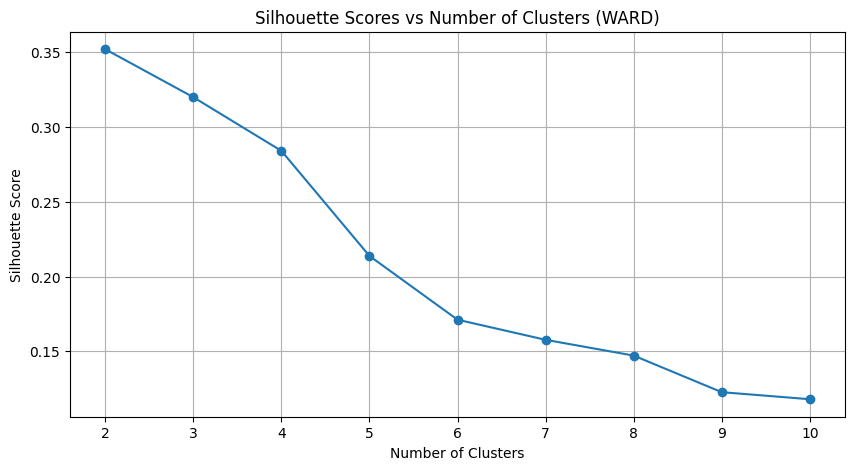

In [ ]:
max_clusters = 10  # Tester jusqu'à 10 clusters
silhouette_scores_ward = []
for k in range(2, max_clusters + 1):
    agglo_clustering = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
    clusters_auto = agglo_clustering.fit_predict(X_norm)
    silhouette_avg = silhouette_score(X_norm, clusters_auto)
    silhouette_scores_ward.append((k, silhouette_avg))

# Tracer les scores de silhouette
plt.figure(figsize=(10, 5))
plt.plot(range(2, max_clusters + 1), [s[1] for s in silhouette_scores_ward], marker='o')
plt.title('Silhouette Scores vs Number of Clusters (WARD)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

## Clustering avec AVERAGE



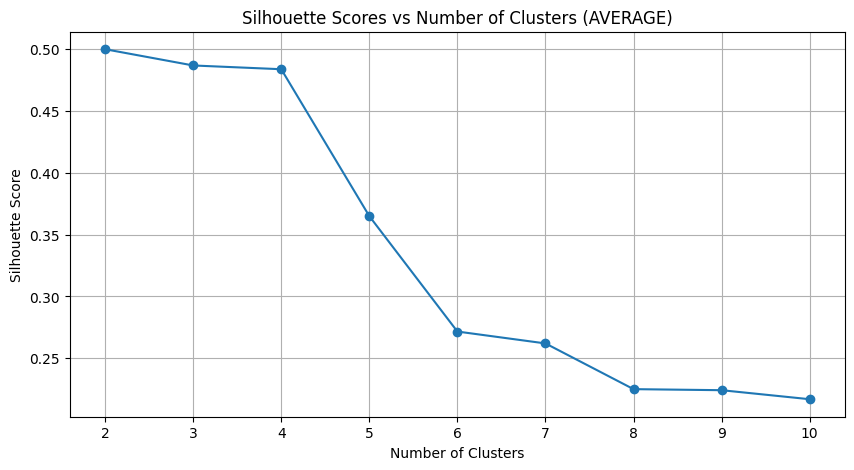

In [ ]:
max_clusters = 10  # Tester jusqu'à 10 clusters
silhouette_scores_average = []
for k in range(2, max_clusters + 1):
    agglo_clustering = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='average')
    clusters_auto = agglo_clustering.fit_predict(X_norm)
    silhouette_avg = silhouette_score(X_norm, clusters_auto)
    silhouette_scores_average.append((k, silhouette_avg))

# Tracer les scores de silhouette
plt.figure(figsize=(10, 5))
plt.plot(range(2, max_clusters + 1), [s[1] for s in silhouette_scores_average], marker='o')
plt.title('Silhouette Scores vs Number of Clusters (AVERAGE)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

In [ ]:
# Meilleur nombre de clusters selon l'indice de silhouette
best_k_average = max(silhouette_scores_average, key=lambda x: x[1])[0]

print (best_k_average)

2


In [ ]:
# Calcul des metriques pour les K avec les silhouettes scores plus élevées

for k in range(2,5):
  agglo_cluster = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='average')
  new_data[f"cluster_{k}"] = agglo_cluster.fit_predict(X_norm)

   #Mapper les clusters vers les sentiments réels
  new_data[f"Predicted_Sentiments_{k}"] = map_clusters_to_sentiments(
    new_data[f"cluster_{k}"], new_data['sentiment']  # Utilise la colonne 'sentiment' pour la correspondance
  )

  # Calculer les métriques Precision / Recall / F1-Score
  print(f"\nÉvaluation pour K = {k} :")
  precision_best, recall_best, f1_best = evaluate_clusters(new_data['sentiment'], new_data[f"Predicted_Sentiments_{k}"])
  print(f"Resultats: Precision={precision_best:2f}, Recall={recall_best:2f}, F1 Score={f1_best:2f}")




Évaluation pour K = 2 :
Resultats: Precision=0.295625, Recall=0.366067, F1 Score=0.229995

Évaluation pour K = 3 :
Resultats: Precision=0.295625, Recall=0.366067, F1 Score=0.229995

Évaluation pour K = 4 :
Resultats: Precision=0.295625, Recall=0.366067, F1 Score=0.229995


## Dendogramme

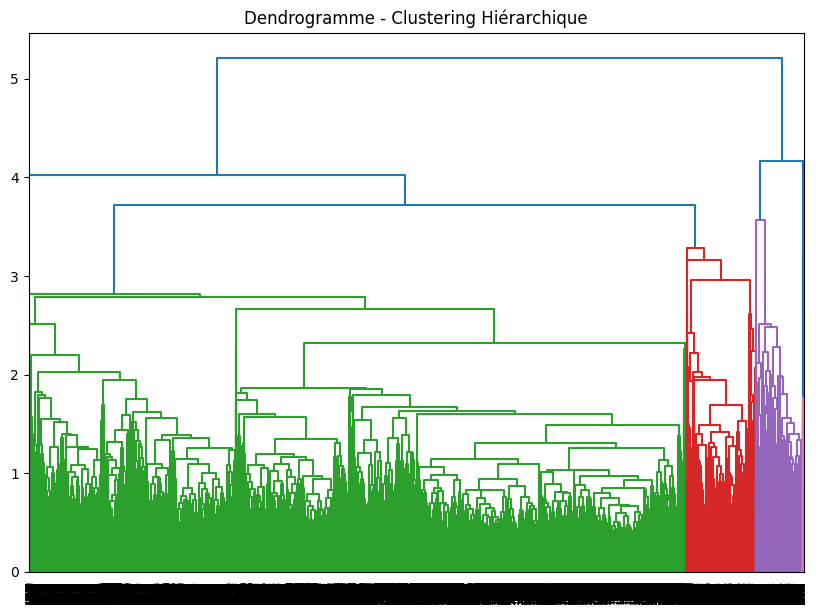

In [ ]:
# Données (X est votre dataset normalisé)
linkage_matrix = linkage(X_norm, method='average')

# Dendrogramme
plt.figure(figsize=(10, 7))
# plt.axhline(y=225,c='black')
dendrogram(linkage_matrix)
plt.title("Dendrogramme - Clustering Hiérarchique")
plt.show()


# Evaluation for `K=3` (Hierarchical Clustering)

In [ ]:
# Clustering pour le meilleur K
agglo_clustering_best = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='average')
new_data['cluster_h3'] = agglo_clustering_best.fit_predict(X_norm)

# Mapper les clusters vers les sentiments réels
new_data['Predicted_Sentiments_h3'] = map_clusters_to_sentiments(
    new_data['cluster_h3'], new_data['sentiment']
)

In [ ]:
# Calculer les métriques Precision / Recall / F1-Score
report = classification_report(
    new_data['sentiment'],
    new_data['Predicted_Sentiments_h3'],
    target_names=["Négatif", "Neutre", "Positif"]
)
print(f"\nÉvaluation pour K = 3 :")
print(report)


Évaluation pour K = 3 :
              precision    recall  f1-score   support

     Négatif       0.00      0.00      0.00     10000
      Neutre       0.36      1.00      0.52     10000
     Positif       0.53      0.10      0.17     10000

    accuracy                           0.37     30000
   macro avg       0.30      0.37      0.23     30000
weighted avg       0.30      0.37      0.23     30000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
